# Prompting Language Models

In ths notebook, we'll be evaluating different model prompting strategies on a publicly available language model. We will then perform soft-prompt tuning on GPT-2 and compare it against hard prompting.

## Install required packages

In [1]:
#!pip install transformers
#!pip install inflect
#!pip install cohere

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import pickle as pkl
import os
import json
import cohere
import random
import inflect
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import nn
import time
from collections import deque

random.seed(0)
np.random.seed(0)

# Load the dataset

We will be using the Common Sense QA dataset, which is a collection of questions about everyday life. The cells below download the data from https://www.tau-nlp.sites.tau.ac.il/commonsenseqa .

In [3]:
# Load dataset from jsonl file
def make_dataset(path):
    dataset = []
    with open(path) as f:
        for line in f:
            dataset.append(json.loads(line))
    return dataset

In [5]:
#@title download the dataset
!curl https://s3.amazonaws.com/commensenseqa/train_rand_split.jsonl -o train_rand_split.jsonl
!curl https://s3.amazonaws.com/commensenseqa/dev_rand_split.jsonl -o dev_rand_split.jsonl
!curl https://s3.amazonaws.com/commensenseqa/test_rand_split_no_answers.jsonl -o test_rand_split_no_answers.jsonl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 73 3697k   73 2731k    0     0  2557k      0  0:00:01  0:00:01 --:--:-- 2557k
100 3697k  100 3697k    0     0  3205k      0  0:00:01  0:00:01 --:--:-- 3206k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  460k  100  460k    0     0   688k      0 --:--:-- --:--:-- --:--:--  689k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:

In [6]:
train_set = make_dataset('train_rand_split.jsonl')
val_set = make_dataset('dev_rand_split.jsonl')

# Print the lengths of the train and validation sets
print(len(train_set), len(val_set))

9741 1221


Here are a few examples of the dataset format:

In [7]:
val_set[:3]

[{'answerKey': 'A',
  'id': '1afa02df02c908a558b4036e80242fac',
  'question': {'question_concept': 'revolving door',
   'choices': [{'label': 'A', 'text': 'bank'},
    {'label': 'B', 'text': 'library'},
    {'label': 'C', 'text': 'department store'},
    {'label': 'D', 'text': 'mall'},
    {'label': 'E', 'text': 'new york'}],
   'stem': 'A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?'}},
 {'answerKey': 'A',
  'id': 'a7ab086045575bb497933726e4e6ad28',
  'question': {'question_concept': 'people',
   'choices': [{'label': 'A', 'text': 'complete job'},
    {'label': 'B', 'text': 'learn from each other'},
    {'label': 'C', 'text': 'kill animals'},
    {'label': 'D', 'text': 'wear hats'},
    {'label': 'E', 'text': 'talk to each other'}],
   'stem': 'What do people aim to do at work?'}},
 {'answerKey': 'B',
  'id': 'b8c0a4703079cf661d7261a60a1bcbff',
  'question': {'question_concept': 'magazines',
   'choices': [{'label': 'A', 't

Make an Cohere account, generate a **trial** API key at https://dashboard.cohere.ai/api-keys, and paste it below.

In [8]:
# Set the api key from https://dashboard.cohere.ai/api-keys
# my trial API
# MingZwhy

co = cohere.Client('DVlh1qOXWwaTCNthG68iZQUR8g4B2YOWW9pxxmS6')

In this notebook, we'll explore different hard-prompting strategies. Run the cells below to see a few example strategies.

In [9]:
def make_simple_prompt(data_point):
    prompt = f"""{data_point['question']['stem']}
 {data_point['question']['choices'][0]['label']} {data_point['question']['choices'][0]['text']}
 {data_point['question']['choices'][1]['label']} {data_point['question']['choices'][1]['text']}
 {data_point['question']['choices'][2]['label']} {data_point['question']['choices'][2]['text']}
 {data_point['question']['choices'][3]['label']} {data_point['question']['choices'][3]['text']}
 {data_point['question']['choices'][4]['label']} {data_point['question']['choices'][4]['text']}
"""
    return prompt

def make_simple_qa_prompt(data_point):
    prompt = f"""Question: {data_point['question']['stem']}
Choice {data_point['question']['choices'][0]['label']}: {data_point['question']['choices'][0]['text']}
Choice {data_point['question']['choices'][1]['label']}: {data_point['question']['choices'][1]['text']}
Choice {data_point['question']['choices'][2]['label']}: {data_point['question']['choices'][2]['text']}
Choice {data_point['question']['choices'][3]['label']}: {data_point['question']['choices'][3]['text']}
Choice {data_point['question']['choices'][4]['label']}: {data_point['question']['choices'][4]['text']}
Answer:"""
    return prompt

def get_instruction():
    return "Answer the following question with A, B, C, D, or E.\n"

def make_qa_instruction_prompt(data_point):
    prompt = get_instruction()
    prompt += make_simple_qa_prompt(data_point)
    return prompt

def make_few_shot_prompt(data_point, num_shots):
    prompt = get_instruction()
    for i in range(num_shots):
        prompt += make_simple_qa_prompt(train_set[i])
        prompt += f" {train_set[i]['answerKey']}\n"
    prompt += make_simple_qa_prompt(data_point)
    return prompt

# This is like the prompt above, but the answers in the examples given are random, not the correct answer
def make_incorrect_few_shot_prompt(data_point, num_shots):
    prompt = get_instruction()
    for i in range(num_shots):
        prompt += make_simple_prompt(train_set[i])
        valid_answers = ['A', 'B', 'C', 'D', 'E']
        valid_answers.remove(train_set[i]['answerKey'])
        # Randomly choose an incorrect answer
        random_answer = random.choice(valid_answers)
        prompt += f"{random_answer}\n"
    prompt += make_simple_qa_prompt(data_point)
    return prompt

In [10]:
# Print one example of each prompt type
print('='*40, 'Simple Prompt', '='*40)
print(make_simple_prompt(train_set[0]))
print('='*40, 'Simple QA Prompt', '='*40)
print(make_simple_qa_prompt(train_set[0]))
print('='*40, 'QA Instruction Prompt', '='*40)
print(make_qa_instruction_prompt(train_set[0]))
print('='*40, 'Few Shot Prompt', '='*40)
print(make_few_shot_prompt(train_set[8], 4))
print('='*40, 'Incorrect Few Shot Prompt', '='*40)
print(make_incorrect_few_shot_prompt(train_set[8], 4))

======================================== Simple Prompt ========================================
The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
 A ignore
 B enforce
 C authoritarian
 D yell at
 E avoid

======================================== Simple QA Prompt ========================================
Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
Choice A: ignore
Choice B: enforce
Choice C: authoritarian
Choice D: yell at
Choice E: avoid
Answer:
======================================== QA Instruction Prompt ========================================
Answer the following question with A, B, C, D, or E.
Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
Choice A: ignore
Choice B: enforce
Choice C: authoritarian
Choice D: yell at
Choice E: avoid
Answer

# Running the model

The cells below contain code to query Cohere's command-xlarge-nightly model. You can read more about it here: https://docs.cohere.ai/reference/generate.

The algorithm is as follows:
1. Format the multiple-choice question as a prompt such that the expected continuation is the answer to the question.
2. Query the model with the prompt.
3. Parse the model's response to extract the answer.


Since we are using the trial keys, we are rate limited to 5 queries per minute. We have implemented the code to wait for a minute if you get close to the rate limit. If you run into rate limits, just wait a bit and retry. (Previous queries will stay in the cache, so you won't have to re-query them.)

In [11]:
# Parameters for the query.
# Run with the defaults first, then if you want try changing them to see how it affects the results
model = "command-xlarge-nightly"  # This is the biggest (and most expensive) model. You can also try "xlarge" or "medium"
temperature = 0 # Control randomness. For more randomness, set to a higher value. For QA, we recommend 0.0
max_tokens = 1 # Only generate 1 token (the answer). The Cohere API
num_generations = 5 # How many outputs to generate
return_likelihoods = 'GENERATION'  # Return the likelihoods for the generations

# To avoid errors due to hitting API rate limits, we'll maintain a running tracker of queries made in the last minute
MAX_QUERIES = 5   # 5 queries per 60s in the cohere free tier
QUERY_TIMEWINDOW = 60 # seconds
timestamps = deque()

def query_cohere(prompt):
    response = co.generate(
      model=model,
      prompt=prompt,
      temperature=temperature,
      max_tokens=max_tokens,
      num_generations=num_generations,
      return_likelihoods=return_likelihoods,
    )
    return response


# We will store the results in a cache so we don't have to query Cohere every time
# This will avoid hitting the API rate limit
cache = {}
if os.path.exists('cache.pkl'):
    with open('cache.pkl', 'rb') as f:
        cache = pkl.load(f)

def post_process_response_text(response):
    """Removes trailing and preceding whitespace and newlines. Returns the first character of the response."""
    r = response.strip()
    if r:
        return r[0]
    return r

# Return the log probability of the correct answer and the most probable answer
def query_model(prompt, correct_answer):
    global query_count, timestamps
    # Check if the query is in the cache
    inputs = (prompt, correct_answer, model, temperature, max_tokens, return_likelihoods)
    if inputs in cache:
        response = cache[inputs]
    else:
        # If more than 5 queries have been run in the last 60s, wait for cooldown
        if len(timestamps) >= MAX_QUERIES and time.time() - timestamps[0] <= QUERY_TIMEWINDOW:
            print("Sleeping for a minute to cooldown API limits.")
            time.sleep(60)
            timestamps.clear()

        # Run query
        response = query_cohere(prompt)

        # Update timestamps
        timestamps.append(time.time())
        if len(timestamps) > MAX_QUERIES:
            timestamps.popleft()

        # Cache inputs
        cache[inputs] = response
        # Save cache to file
        with open('cache.pkl', 'wb') as f:
            pkl.dump(cache, f)
    log_prob = response.data[0].likelihood
    most_probable = post_process_response_text(response.data[0].text)
    return log_prob, most_probable

In [13]:
# For simplicity (and to save time), we'll only use the first 10 data points
# You can get more reliable results by using more data points, but it will
# take longer to run because of API rate limits.
num_points = 10
mini_train = val_set[:num_points]
num_shots = 4

# Consider adding additional prompts of your own here.
prompt_strategies = {
    'simple': make_simple_prompt,
    'simple_qa': make_simple_qa_prompt,
    'qa_instruction': make_qa_instruction_prompt,
    'few_shot': lambda x: make_few_shot_prompt(x, num_shots),
    'incorrect_few_shot': lambda x: make_incorrect_few_shot_prompt(x, num_shots)
}

def compute_acc(data_points, prompt_strategy):
    accuracies = []
    valid_responses = []
    for data_point in data_points:
        print(f'Question: {data_point["question"]["stem"]}, Answer: {data_point["answerKey"]}, Choices: {[choice["text"] for choice in data_point["question"]["choices"]]}')
        prompt = prompt_strategy(data_point)
        correct_answer = f'{data_point["answerKey"]}'

        log_prob, most_probable = query_model(prompt, correct_answer)
        accuracies += [int(most_probable == correct_answer)]
        valid_responses += [most_probable in ['A', 'B', 'C', 'D', 'E']]
        print(f'   LM predicted |{most_probable}|, accuracy: {accuracies[-1]}')
    return np.mean(accuracies), np.mean(valid_responses)

def plot_all_accs(data_points, prompt_strategies):
    accuracies = []
    valid_responses = []
    for prompt_name, prompt_strategy in prompt_strategies.items():
        accuracy, valid_rate = compute_acc(data_points, prompt_strategy)
        accuracies += [accuracy]
        valid_responses += [valid_rate]
    # Plot a bar chart of the accuracies
    plt.figure(figsize=(10, 5))
    plt.bar(prompt_strategies.keys(), accuracies)
    plt.title('Accuracies')
    plt.show()
    # Plot a bar chart of the valid responses
    plt.figure(figsize=(10, 5))
    plt.bar(prompt_strategies.keys(), valid_responses)
    plt.title('Valid Responses')
    plt.show()



Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?, Answer: A, Choices: ['bank', 'library', 'department store', 'mall', 'new york']
   LM predicted |E|, accuracy: 0
Question: What do people aim to do at work?, Answer: A, Choices: ['complete job', 'learn from each other', 'kill animals', 'wear hats', 'talk to each other']
   LM predicted |A|, accuracy: 1
Question: Where would you find magazines along side many other printed works?, Answer: B, Choices: ['doctor', 'bookstore', 'market', 'train station', 'mortuary']
   LM predicted |B|, accuracy: 1
Question: Where are  you likely to find a hamburger?, Answer: A, Choices: ['fast food restaurant', 'pizza', 'ground up dead cows', 'mouth', 'cow carcus']
   LM predicted |A|, accuracy: 1
Question: James was looking for a good place to buy farmland.  Where might he look?, Answer: A, Choices: ['midwest', 'countryside', 'estate', 'farming areas', 'illinois']
   LM predicted |E|, ac

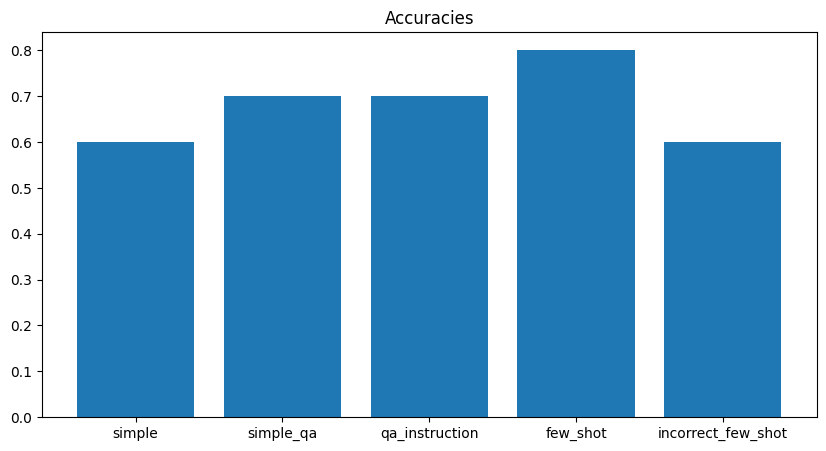

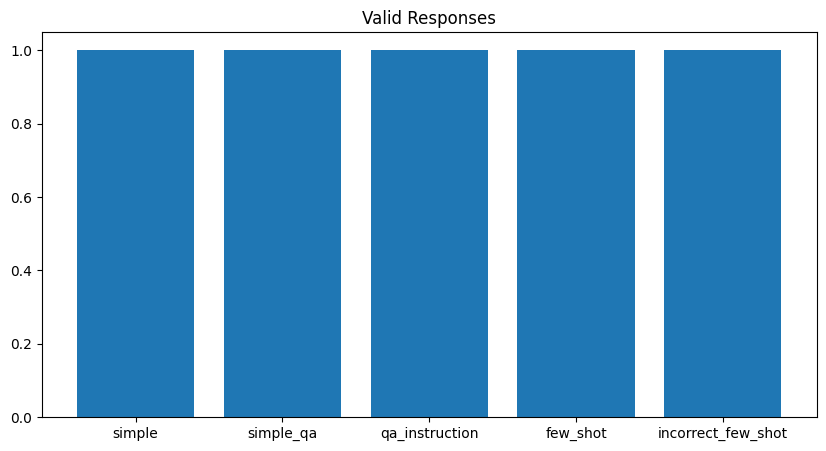

In [14]:
plot_all_accs(mini_train, prompt_strategies)

# Analysis

TODO: in the cells below, implement code to analyze the model's performance.
* What kinds of failures do you see with different prompting strategies?
* Does providing correct labels in few-shot prompting have a significant impact on accuracy?
* Observe the model’s log probabilities. Does it seem more confident when it is correct than when it is incorrect?

A function to plot the model's confidence has been implemented for you, but you should feel free to write code to do additional analysis.


Prompt: Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
Choice A: bank
Choice B: library
Choice C: department store
Choice D: mall
Choice E: new york
Answer:
LM predicted |A|, correct answer: A
Prompt: Question: What do people aim to do at work?
Choice A: complete job
Choice B: learn from each other
Choice C: kill animals
Choice D: wear hats
Choice E: talk to each other
Answer:
LM predicted |C|, correct answer: A
Prompt: Question: Where would you find magazines along side many other printed works?
Choice A: doctor
Choice B: bookstore
Choice C: market
Choice D: train station
Choice E: mortuary
Answer:
LM predicted |B|, correct answer: B
Prompt: Question: Where are  you likely to find a hamburger?
Choice A: fast food restaurant
Choice B: pizza
Choice C: ground up dead cows
Choice D: mouth
Choice E: cow carcus
Answer:
LM predicted |A|, correct answer: A
Prompt: Question: James was looking for a good place to buy farmla

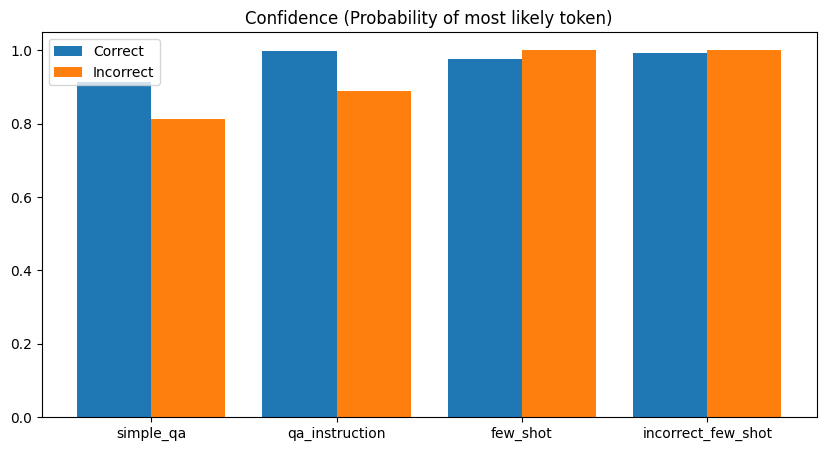

In [15]:
# Printing the log probs for the generated tokens
prompt_strategies = {
    # 'simple': make_simple_prompt, # removed since it's always incorrect
    'simple_qa': make_simple_qa_prompt,
    'qa_instruction': make_qa_instruction_prompt,
    'few_shot': lambda x: make_few_shot_prompt(x, num_shots),
    'incorrect_few_shot': lambda x: make_incorrect_few_shot_prompt(x, num_shots)
}

argmax_lp_correct = []
argmax_lp_incorrect = []
for prompt_name, prompt_strategy in prompt_strategies.items():
    argmax_lp_correct_prompt = []
    argmax_lp_incorrect_prompt = []
    for data_point in val_set[:num_points]:
        prompt = prompt_strategy(data_point)
        correct_answer = f'{data_point["answerKey"]}'
        print(f"Prompt: {prompt}")
        log_probs, most_probable = query_model(prompt, correct_answer)
        log_prob_argmax = log_probs
        if most_probable == correct_answer:
            argmax_lp_correct_prompt += [log_prob_argmax]
        else:
            argmax_lp_incorrect_prompt += [log_prob_argmax]
        print(f'LM predicted |{most_probable}|, correct answer: {correct_answer}')

    argmax_lp_correct += [np.mean(argmax_lp_correct_prompt)]
    argmax_lp_incorrect += [np.mean(argmax_lp_incorrect_prompt)]

# Plot a bar chart of the accuracies. The bar chart has two bars for each prompt strategy.
# These bars are placed side by side, so you can compare the accuracies of the two strategies.
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(prompt_strategies)) - 0.2, np.exp(argmax_lp_correct), width=0.4, label='Correct')
plt.bar(np.arange(len(prompt_strategies)) + 0.2, np.exp(argmax_lp_incorrect), width=0.4, label='Incorrect')
plt.title('Confidence (Probability of most likely token)')
plt.xticks(np.arange(len(prompt_strategies)), prompt_strategies.keys())
plt.legend()
plt.show()

# Training GPT-2 for soft prompt tuning

GPT-2 is the smaller predecessor model to GPT-3. We will use GPT-2 for soft prompt tuning as it is
publicly available(unlike GPT-3) and small enough to train on the free version of the colab GPU
(unlike GPT-J).

Soft prompt tuning is described in this [paper](https://arxiv.org/abs/2104.08691v1), which we encourage you to learn more about. In essence, instead of generating answers by putting in token prompts, we use fine tuning to train the embeddings of new learned tokens. This allows us to generate answers by putting in the new learned tokens instead of tokens which correspond to real words.

Most of the code has been implemented for you, but you should still read through the code to understand what it's doing. There is one TODO which asks you to set up the optimizer. Think about which parameters should get passed into the optimizer.


In [16]:
#@title Define soft embedding for GPT-2
#@markdown code adapted from [this github repo](https://github.com/kipgparker/soft-prompt-tuning) implementing the [soft prompt tuning paper](https://arxiv.org/abs/2104.08691v1)
class SoftEmbedding(nn.Module):
    def __init__(self,
                wte: nn.Embedding,
                n_tokens: int = 10,
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        """
        Here, we concatentate a new task-specific learned embedding to the existing GPT-2 embedding.
        Args:
            wte (nn.Embedding): original transformer word embedding
            n_tokens (int, optional): number of tokens for task. Defaults to 10.
            random_range (float, optional): range to init embedding (if not initialize from vocab). Defaults to 0.5.
            initialize_from_vocab (bool, optional): initalizes from default vocab. Defaults to True.
        """
        super(SoftEmbedding, self).__init__()
        self.wte = wte
        self.n_tokens = n_tokens
        self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte,
                                                                               n_tokens,
                                                                               random_range,
                                                                               initialize_from_vocab))

    def initialize_embedding(self,
                             wte: nn.Embedding,
                             n_tokens: int = 10,
                             random_range: float = 0.5,
                             initialize_from_vocab: bool = True):
        """initializes learned embedding
        Args:
            same as __init__
        Returns:
            torch.float: initialized using original schemes
        """
        if initialize_from_vocab:
            return self.wte.weight[:n_tokens].clone().detach()
        return torch.FloatTensor(n_tokens, wte.weight.size(1)).uniform_(-random_range, random_range)

    def forward(self, tokens):
        """run forward pass
        Args:
            tokens (torch.long): input tokens before encoding
        Returns:
            torch.float: encoding of text concatenated with learned task specifc embedding
        """
        # The first n_tokens embeddings are reserved for the learned embeddings
        # The rest of the embeddings are the original GPT-2 embeddings
        input_embedding = self.wte(tokens[:, self.n_tokens:])
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
        return torch.cat([learned_embedding, input_embedding], 1)

In [17]:
#@markdown Set up a soft embedding version of GPT-2
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", padding_side='left')
tokenizer.pad_token=tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_tokens = 100

def initialize_soft_model():
    model = GPT2LMHeadModel.from_pretrained('gpt2')

    initialize_from_vocab = True

    # Set the input embeddings to the GPT2 model
    s_wte = SoftEmbedding(model.get_input_embeddings(),
                        n_tokens=n_tokens,
                        initialize_from_vocab=initialize_from_vocab)
    model.set_input_embeddings(s_wte)
    model.to(device)
    return model

# While we didn't need to do this for GPT-3 earlier, training the model means we need to turn the text
# into tokens that the model can understand via the embedding layer.
def process_dataset(dataset, mapper_fn, pad_length=119):
    mapped_dataset = [mapper_fn(item) for item in dataset]
    if pad_length is None:
        out = tokenizer(mapped_dataset, return_tensors='pt', padding=True)
    else:
        out = tokenizer(mapped_dataset, return_tensors='pt', padding="max_length", max_length=pad_length)
    # Need to add a space as GPT differentiates between " A" and "A" and it will be predicting " A".
    answerkey = [' ' + item['answerKey'] for item in dataset]
    out['answerkey'] = tokenizer(answerkey, return_tensors='pt', max_length=1)['input_ids']
    return out

def pad_soft_inputs(inputs):
    """
    We need to pad the attention_mask and input_ids with an extra n_learned_tokens
    It does not matter what you pad input_ids with since these will be overwritten by learned embeddings
    """
    batch = len(inputs['input_ids'])
    inputs['input_ids'] = torch.cat([torch.full((batch, n_tokens), 50256).to(device), inputs['input_ids'].to(device)], 1).to(device)
    inputs['attention_mask'] = torch.cat([torch.full((batch, n_tokens), 1).to(device), inputs['attention_mask'].to(device)], 1).to(device)
    return inputs

# Train the model
def train_model(model, train_set, val_set, dataset_processor, batch_size=8, epochs=1, lr=1e-4, print_every=100):
    train_dataset = process_dataset(train_set, dataset_processor)
    val_dataset = process_dataset(val_set, dataset_processor)
    
    # Get the parameters of the new embedding layer
    new_embedding_params = list(model.get_input_embeddings().parameters())
    parameters_to_train = new_embedding_params
    
    optimizer = torch.optim.Adam(parameters_to_train, lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    model.train()
    epoch_train_losses = []
    for i in range(epochs):
        epoch_loss = 0
        for j in range(0, len(train_dataset['input_ids']), batch_size):
            # Calculate cross entropy loss between predicted last token and actual last token
            optimizer.zero_grad()
            inputs = {k: v[j:j+batch_size].to(device) for k, v in train_dataset.items()}
            inputs = pad_soft_inputs(inputs)
            labels = inputs.pop('answerkey')
            outputs = model(**inputs).logits[:, -1, :] # (batch_size, vocab_size)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            # loss calculated by criterion is averaged over batch, so multiply by batch size to get total loss
            epoch_loss += loss.item() * labels.shape[0]
            if j % print_every == 0:
                print(f'Epoch {i}, Item {j}, loss: {loss.item()}')
        epoch_loss /= train_dataset['input_ids'].shape[0]
        epoch_train_losses.append(epoch_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        for j in range(0, len(val_dataset['input_ids']), batch_size):
            inputs = {k: v[j:j+batch_size].to(device) for k, v in val_dataset.items()}
            inputs = pad_soft_inputs(inputs)
            labels = inputs.pop('answerkey')
            outputs = model(**inputs).logits[:, -1, :]
            if j == 0: print(f'decoding {tokenizer.decode(outputs.argmax(dim=-1))}')
            loss = criterion(outputs, labels.squeeze())
            val_loss += loss.item() * labels.shape[0]
        val_loss /= val_dataset['input_ids'].shape[0]
        print('-'*20)
        print(f'Epoch {i}, Validation loss: {val_loss}')


# This function lets us sample the next token (or, in our case, the next answer) from the model.
def generate_output(model, inputs, pad_soft=True):
    """
    Given a string text or a tokenized input (or list of these, if batched), returns the model's prediction for the
    next token in the sequence.
    """
    model.eval()
    if type(inputs) is str or type(inputs) is list and type(inputs[0]) is str:
        inputs = tokenizer(inputs, return_tensors="pt").to(device)

    if pad_soft:
        inputs = pad_soft_inputs(inputs)
    outputs = model(**inputs).logits[0, -1, :]
    outputs = outputs.argmax(dim=-1)
    return tokenizer.decode(outputs)



d:\Anaconda\Anaconda_setup\envs\malning\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cyt\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
model = initialize_soft_model()
hard_embedding_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
print(generate_output(hard_embedding_model, 'Deep learning is an', pad_soft=False))

# Print out the embeddings so you can see their shpaes
print('Embedding object', model.get_input_embeddings())
print('Learned embeddings', model.get_input_embeddings().learned_embedding.shape)
print('Original vocab embeddings', model.get_input_embeddings().wte.weight.shape)

 important
Embedding object SoftEmbedding(
  (wte): Embedding(50257, 768)
)
Learned embeddings torch.Size([100, 768])
Original vocab embeddings torch.Size([50257, 768])


In [19]:
prompt_strategy = 'qa_instruction'
if prompt_strategy not in prompt_strategies:
    print('prompt strategy must be one of', [i for i in prompt_strategies])
else:
    prompt_strategy = prompt_strategies[prompt_strategy]
    train_model(model, train_set, val_set, prompt_strategy, batch_size=8, epochs=2) # you can reduce the batch size if you run out of memory


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 0, Item 0, loss: 5.640458106994629


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 │   print('prompt strategy must be one of', [i for i in prompt_strategies])                  │
│   4 else:                                                                                        │
│   5 │   prompt_strategy = prompt_strategies[prompt_strategy]                                     │
│ ❱ 6 │   train_model(model, train_set, val_set, prompt_strategy, batch_size=8, epochs=2) # yo     │
│   7                                                                                              │
│                                                                                                  │
│ in train_model:68                                                                                │
│                                                                                                  │
│    65 │   │   │   labels = inputs.pop('answerkey')                                               │
│    66 │   │   │   outputs = model(**inputs).logits[:, -1, :] # (batch_size, vocab_size)          │
│    67 │   │   │   loss = criterion(outputs, labels.squeeze())                                    │
│ ❱  68 │   │   │   loss.backward()                                                                │
│    69 │   │   │   optimizer.step()                                                               │
│    70 │   │   │   # loss calculated by criterion is averaged over batch, so multiply by batch    │
│    71 │   │   │   epoch_loss += loss.item() * labels.shape[0]                                    │
│                                                                                                  │
│ d:\Anaconda\Anaconda_setup\envs\malning\lib\site-packages\torch\_tensor.py:489 in backward       │
│                                                                                                  │
│    486 │   │   │   │   inputs=inputs,                                                            │
│    487 │   │   │   )                                                                             │
│    488 │   │   torch.autograd.backward(                                                          │
│ ❱  489 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    490 │   │   )                                                                                 │
│    491 │                                                                                         │
│    492 │   def register_hook(self, hook):                                                        │
│                                                                                                  │
│ d:\Anaconda\Anaconda_setup\envs\malning\lib\site-packages\torch\autograd\__init__.py:199 in      │
│ backward                                                                                         │
│                                                                                                  │
│   196 │   # calls in the traceback and some print out the last line                              │
│   197 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   198 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│ ❱ 199 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   200                                                                                            │
│   201 def grad(                                                                                  │
│   202 │   outputs: _TensorOrTensors,                                                             │
╰────────────────────────────────────────────────────────────

In [ ]:
# Save the model to a pickle file (If your runtime crashes, you can load the model from this file)
with open('soft_embeddings_model_qa.pkl', 'wb') as f:
    pkl.dump(model, f)

Compare the performance of the model with hard prompting and with soft prompt tuning. If your implementation is correct, you should get around 21% correct and 0% invalid with the soft prompt. Answer the analysis questions in the written portion of the assignment.

In [ ]:
#@title Let's compare a few examples from our prompts
def compare_models(model1, model1_pad_soft, model2, model2_pad_soft, dataset, dataset_processor, n_entries=5):
    processed_set = process_dataset(dataset, dataset_processor)
    for i in range(n_entries):
        data_point_idx = np.random.choice(len(dataset))
        point = dataset[data_point_idx]
        processed_point = processed_set[data_point_idx]
        prompt = dataset_processor(point)
        print(prompt)
        output1 = generate_output(model1, dataset_processor(point), pad_soft=model1_pad_soft)
        output2 = generate_output(model2, dataset_processor(point), pad_soft=model2_pad_soft)
        print(f'gt: {point["answerKey"]}. model1: {repr(output1)}. model2: {repr(output2)}')
        print('-' * 20)


compare_models(model, True, hard_embedding_model, False, val_set, prompt_strategy)

In [ ]:
#@title Bar plot the distribution of incorrect answers, invalid answers, and correct answers
def get_answer_stats(model, dataset, dataset_processor, verbose, pad_soft):
    processed_set = process_dataset(dataset, dataset_processor)
    correct = 0
    incorrect = 0
    invalid = 0
    for i in range(len(dataset)):
        inputs = {k: v[i:i+1].to(device) for k, v in processed_set.items()}
        point = dataset[i]
        prompt = dataset_processor(point)
        label = inputs.pop('answerkey')
        output = generate_output(model, inputs, pad_soft).strip()
        if verbose: print(f'Prompt: {prompt}, output: |{output}|, answerkey |{point["answerKey"]}|')
        if output == point["answerKey"]:
            correct += 1
        elif output in ['A', 'B', 'C', 'D', 'E'] or not point['answerKey'] in ['A', 'B', 'C', 'D', 'E']:
            incorrect += 1
        else:
            invalid += 1
    correct, incorrect, invalid = correct/len(dataset), incorrect/len(dataset), invalid/len(dataset)
    return correct, incorrect, invalid

def plot_answer_stats(model, dataset, dataset_processor, verbose=False, pad_soft=True):
    correct, incorrect, invalid = get_answer_stats(model, dataset, dataset_processor, verbose, pad_soft)
    plt.bar(['correct', 'incorrect', 'invalid'], [correct, incorrect, invalid])
    plt.title('Answer distribution')
    plt.show()

In [ ]:
plot_answer_stats(model, val_set, prompt_strategy, verbose=True, pad_soft=True)

In [ ]:
plot_answer_stats(hard_embedding_model, val_set, prompt_strategies['qa_instruction'], pad_soft=False, verbose=False)

In [ ]:
model_soft_qa = model

# Pluralize task

As you can see above, the soft embedding model does not perform very well on this task. We'll show how soft prompting does better on a second, very simple task - pluralizing a word.

The dataset we use was found here, and consists of a list of English nouns: https://www.kaggle.com/datasets/leite0407/list-of-nouns?select=nounlist.csv.
For simplicity, we will only consider words where the output is a single token (to avoid needing to deal with sequential generation for evaluation), but you could adapt the code to generate arbitrarily long outputs.

If you get memory errors when running this part, re-run the notebook while skipping loading the previous dataset and soft model.


!! If you run into an error during training complaining about batch size dimensions, this is an edge-case issue where we get errors when the last batch in an epoch length 1. You can fix this by removing the item in the train set. !!

In [ ]:
!curl https://inst.eecs.berkeley.edu/~cs182/fa22/assets/assignments/nounlist.csv -o nounlist.csv

We'll create targets for this dataset using the inflect library, which is a Python library for inflecting English words. You can read more about it here: https://pypi.org/project/inflect/. This library can convert word to plural forms (though it is not 100% reliable).

In [ ]:
# Set of words with unusual plurals
noun_test = ['foot', 'man', 'person', 'self', 'wife', 'wolf', 'woman']

engine = inflect.engine()

# Load new noun_list dataset from csv file
with open('nounlist.csv', 'r') as f:
    noun_list = f.read().splitlines()
    noun_list = [i.strip() for i in noun_list]
random.seed(0)
# shuffle the noun list
random.shuffle(noun_list)
# Remove all list items which are in the nouns list (our test set)
noun_list = [i for i in noun_list if i not in noun_test]
# Remove the last 10% for validation
noun_train = noun_list[:-int(len(noun_list)*0.1)]
noun_val = noun_list[-int(len(noun_list)*0.1):]

# Plural task
def format_dataset(noun_list):
    dataset = []
    for noun in noun_list:
        plural = engine.plural(noun)
        dataset.append({'answerKey': plural, 'input': noun})
    return dataset


noun_train = format_dataset(noun_train)
noun_val = format_dataset(noun_val)
noun_test = format_dataset(noun_test)


# Only include nouns where the plural is a single token
noun_train = [i for i in noun_train if len(tokenizer(i['answerKey'])['input_ids']) == 1]
noun_val = [i for i in noun_val if len(tokenizer(i['answerKey'])['input_ids']) == 1]
noun_test = [i for i in noun_test if len(tokenizer(i['answerKey'])['input_ids']) == 1]

# Print the first 10 items in the dataset
print([point['input'] for point in noun_train[:10]])
print([point['answerKey'] for point in noun_train[:10]])

print(f'Lengths: train: {len(noun_train)}, val: {len(noun_val)}, test: {len(noun_test)}')

Compare hard prompting with soft prompting on this task, then answer the analysis questions in the written part of this homework. You should get over 60% correct on the val set with soft prompting.

In [ ]:
def basic_format(point):
    if isinstance(point, dict):
        point = point['input']
    return f"The plural of {point} is"

examples = ['pasta', 'sweater', 'wave', 'mouse', 'attorney', 'bottle', 'phone', 'grass', 'evening', 'candy', 'flower', 'planet', 'architect', 'washer',
            'keyhole', 'economy', 'grace', 'finance', 'midnight', 'cushion', 'plateau', 'mouse', 'chord', 'cactus', 'swap', 'tremor', 'criterion', 'sink', 'bandana', 'trade'
            ]

def make_few_shot(i):
    def few_shot(point):
        prompt = ''
        for j in range(i):
            prompt += basic_format(examples[j]) + ' ' + engine.plural(examples[j]) + '.\n'
        prompt += basic_format(point)
        return prompt
    return few_shot

In [ ]:
model_pluralize = initialize_soft_model()
train_model(model_pluralize, noun_train, noun_val, basic_format, batch_size=8, epochs=40)

In [ ]:
# Save the model to a pickle file (If your runtime crashes, you can load the model from this file)
with open('soft_embeddings_model_pluralize.pkl', 'wb') as f:
    pkl.dump(model, f)

In [ ]:
plot_answer_stats(model_pluralize, noun_val, basic_format, verbose=True, pad_soft=True)
plot_answer_stats(model_pluralize, noun_test, basic_format, verbose=True, pad_soft=True)

In [ ]:
# Plot results with hard prompts of various lengths
for num_shots in range(10):
    plot_answer_stats(hard_embedding_model, noun_val, make_few_shot(num_shots), verbose=False, pad_soft=True)

# Deliverables

Please submit this completed notebook and complete all the written questions.